# ChromWave Tutorial

c
This notebook is a quick introduction how to train a ChromWave model. As a toy example we will load the nucleosome data from `Kaplan et al 2009`. We further introduce other basic functionalities of the ChromWave object such as saving and loading. 

In [1]:
import matplotlib
from matplotlib import pyplot as plt
import os
import numpy
import pandas
from chromwave import runtime_dataset, filesystem, chromwavenet

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # using only one gpu
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Setting up the directories

You'll need the data in the repository, please make sure you've cloned it and the working directoy points to it.

In [3]:
# working directory should be ChromWave/scripts/Tutorials_Workflows. if not change project dir to be the directory 
# containing the code for ChromWave
project_dir = os.path.abspath(os.path.join(os.getcwd(),'../../../'))
working_dir = os.path.join(project_dir, 'ChromWave')

output_dir = os.path.join(project_dir,'Test')

In [4]:
data_dir = os.path.join(working_dir, 'data')
model_dir = os.path.join(working_dir, 'models')

nuc_profile_inVivo = os.path.join(data_dir,'kaplan2009','Occupancy_inVivo_sacCer1.csv')
nuc_profile_inVitro = os.path.join(data_dir,'kaplan2009','Occupancy_inVitro_sacCer1.csv')


inVitro_nuc_model_dir = os.path.join(model_dir,'nucleosomes/sacCer1_inVitro')
inVivo_nuc_model_dir = os.path.join(model_dir,'nucleosomes/sacCer1_inVivo')

We first set up the FileSystem, passing the location of the genome fa files, the output directory and nucleosome profiles of the in vitro profiles of the Kaplan et al 2009 data. If the output folder was already created we will overwrite as this instance. We have no test data to pass and we split the dataset into 20% test and 10% validation data (and 80% training data). 

We then load the data as a RuntimeDataset object with the underlying FileSystem. The sequences in the training, test and validation data will be shuffled but for testing purposes we use a fixed seed. We include the reverse complements of each sequence and remove sequences if a third of the region has a flat signal. The class weight cap denotes the max at which the class weights (computed as median/frequency per class) are capped to avoid extremely high weights for rarely occuring classes. 

In [5]:
f = filesystem.FileSystem(os.path.join(data_dir,'genomes/sacCer1'), os.path.join(output_dir,'Saliency'), 
                          source_profile=nuc_profile_inVitro, overwrite=True, test_fraction=0.1, 
                          val_fraction=0.2, resume=False)
r = runtime_dataset.RuntimeDataset(f)
r._set_seed = 32
r._shuffle_sequences = True
r._include_rc = True
r.class_weight_cap = [40]
r._remove_unmapped_training_regions = [0.3]
r.data_format = 'processed_counts'

nuc_preprocessing_params = {'times_median_coverage_max': 3, 'discretize_function': 'float_to_int',
                            'assign_non_covered_bases': None, 'u': 2.5, 'smooth_signal': True, 'sigma': 5,
                            'truncate': 3, 'smoothing_function': 'gaussian_filter1d', 'x_thresh': 0,
                            'run_thresh': 50, 'normalise_read_counts': None}

r.preprocessing_params = [nuc_preprocessing_params]
r.step_size = 2000
r.save_data = False
r.load_existing_data = False
r.load_data()


Evaluation and validation data will be generated from the training data with a fractional weighting of: 0.1 and 0.2
Loading genomic data... 
Mitochondrial chromosome will be kept as separate data...
using pre-processing params:
{'times_median_coverage_max': 3, 'discretize_function': 'float_to_int', 'assign_non_covered_bases': None, 'u': 2.5, 'smooth_signal': True, 'sigma': 5, 'truncate': 3, 'smoothing_function': 'gaussian_filter1d', 'x_thresh': 0, 'run_thresh': 50, 'normalise_read_counts': None}
I am assuming that the columns in the provided csv file are: seqname, start, score. If this is not the case, abort and change the input format!
Binding profiles were binned into [22] bins.
Beginning training data load
Removing 1128 fragments that have have too many constant values in all of the provided profiles.
Subsetting training data with test proportion: 0.1 and validation proportion 0.2
Adding reverse complement of genomic sequences and binding profiles for training, test and validation d

# Model set-up

We choose some parameters first, but there are some more that can be chosen. You can see all parameters that can be set and their defaults with the `__dict__` function. 

In [6]:
model = chromwavenet.ChromWaveNet()
model.__dict__

{'n_channels': 4,
 'n_output_features': 1,
 'n_output_bins': [1],
 'kernel_lengths': [24],
 'pool_sizes': [],
 'conv_n_filters': [60],
 '_pretrained_models': [],
 '_pretrained_kernel_lengths': [],
 '_pretrained_conv_n_filters': [],
 '_pool_pretrained_conv': None,
 '_train_pretrained_conv': None,
 'inject_pwm_dir': None,
 'inject_pwm_selection': None,
 'inject_pwm_include_rc': False,
 'n_stacks': 2,
 'dilation_depth': 9,
 'dilation_kernel_size': 2,
 'use_skip_connections': False,
 'learn_all_outputs': True,
 'train_with_soft_target_stdev': False,
 'train_only_in_receptive_field': False,
 'use_bias': False,
 'momentum': 0.9,
 'learning_rate': 0.001,
 'weight_decay': 0.0,
 'nesterov': True,
 'optimizer': 'adam',
 'epsilon': 0.001,
 'amsgrad': False,
 'dropout': 0.3,
 'res_dropout': 0.1,
 'res_l2': 0.0,
 'final_l2': 0.0,
 'minimum_batch_size': 32,
 'max_epochs': 100,
 'early_stopping_patience_fraction': 3,
 'early_stopping': True,
 'reduceLR_rate': 0.1,
 'batch_normalization': False,
 'ker

To see all available methods with a short description you can call the `get_methods()` function:

In [7]:
model.get_methods()

__class__            Object that wraps Keras Wavenet style neural network objects, allowing the tuning of
__delattr__          Implement delattr(self, name).
__dir__              Default dir() implementation.
__eq__               Return self==value.
__format__           Default object formatter.
__ge__               Return self>=value.
__getattribute__     Return getattr(self, name).
__gt__               Return self>value.
__hash__             Return hash(self).
__init__             None
__init_subclass__    This method is called when a class is subclassed. The default implementation does nothing
__le__               Return self<=value.
__lt__               Return self<value.
__ne__               Return self!=value.
__new__              Create and return a new object. See help(type) for accurate signature.
__reduce__           Helper for pickle.
__reduce_ex__        Helper for pickle.
__repr__             Return repr(self).
__setattr__          Implement setattr(self, name, value).
__s

We first select some values for learning rage, l2 regularisation (in both residual block and final layers).  

In [8]:
model.learning_rate = 0.002
model.dropout = 0.2
model.res_l2 = 0.01
model.final_l2 = 0.05

We want to train a simple model fist, so we are turning off early stopping and reducing the learning rate when the loss function plateaus. We do turn on batch normalisation and skip connections as they greatly improve the training. 

In [9]:
model.early_stopping=False
model.reduceLR_rate=None
model.batch_normalization=True
model.use_skip_connections = True

We can now choose the number of epochs we would like to train for and then train the model with the RuntimeDataset and FileSystem objects r and f. Using the train function of the ChromWave object prints out the measures on the training, test and validation set (loss, class accuracy, mean squared error, and Pearson correlation). 

After training, some plots to investigate the quality of the training (history, distribution of class predictions, best and worst predicted sequences in training, test and validation set) and confusion matrices for all data sets are plotted. Predictions for all chromosomes are saved as numpy arrays and motif detectors are computed and saved as csv files. All these results are automatically stored in the directory `wavenet_output` in the output directory. 

In [10]:
model.max_epochs = 2
import time 
start = time.time()
model.train(r,f)
end=time.time()
print('Time: ' + str((end-start)/60.)+' mins')

Receptive Field: 2047 
Train on 6626 samples, validate on 1756 samples
Epoch 1/2
6626/6626 [==============================] - 56s 8ms/step - loss: 138044.4276 - categorical_accuracy: 0.2372 - categorical_mean_squared_error: 7.3413 - mean_classification_pearson_correlation: 0.6484 - val_loss: 158200.6532 - val_categorical_accuracy: 0.1245 - val_categorical_mean_squared_error: 4.9455 - val_mean_classification_pearson_correlation: 0.8688
Epoch 2/2
6626/6626 [==============================] - 41s 6ms/step - loss: 117406.7652 - categorical_accuracy: 0.2919 - categorical_mean_squared_error: 2.5096 - mean_classification_pearson_correlation: 0.7854 - val_loss: 127834.7322 - val_categorical_accuracy: 0.2082 - val_categorical_mean_squared_error: 2.7273 - val_mean_classification_pearson_correlation: 0.8865
Saving model to file ... 
Performance of model on trainings data: 
6626/6626 [==============================] - 11s 2ms/step
[133494.37369094053, 0.2074836939573288, 3.394230842590332, 0.813540

# Basic ChromWave methods 

ChromWaveNet is a wrapper around keras models. The keras model can be accessed through `ChromWaveNet.get_underlying_neural_network()` and is held in `ChromWaveNet._neural_network`. Any Keras functions of models will work. 

In [11]:
model.get_underlying_neural_network()

In [12]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_part (InputLayer)         (None, 2000, 4)      0                                            
__________________________________________________________________________________________________
conv_0 (Conv1D)                 (None, 2000, 60)     5820        input_part[0][0]                 
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 2000, 60)     240         conv_0[0][0]                     
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 2000, 60)     0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

In [13]:
model.layer_names()

['input_part',
 'conv_0',
 'batch_normalization_7',
 'activation_7',
 'dilated_conv_1_tanh_s0',
 'dilated_conv_1_sigm_s0',
 'gated_activation_0_s0',
 'conv1d_85',
 'add_43',
 'dropout_43',
 'dilated_conv_2_tanh_s0',
 'dilated_conv_2_sigm_s0',
 'gated_activation_1_s0',
 'conv1d_87',
 'add_44',
 'dropout_44',
 'dilated_conv_4_tanh_s0',
 'dilated_conv_4_sigm_s0',
 'gated_activation_2_s0',
 'conv1d_89',
 'add_45',
 'dropout_45',
 'dilated_conv_8_tanh_s0',
 'dilated_conv_8_sigm_s0',
 'gated_activation_3_s0',
 'conv1d_91',
 'add_46',
 'dropout_46',
 'dilated_conv_16_tanh_s0',
 'dilated_conv_16_sigm_s0',
 'gated_activation_4_s0',
 'conv1d_93',
 'add_47',
 'dropout_47',
 'dilated_conv_32_tanh_s0',
 'dilated_conv_32_sigm_s0',
 'gated_activation_5_s0',
 'conv1d_95',
 'add_48',
 'dropout_48',
 'dilated_conv_64_tanh_s0',
 'dilated_conv_64_sigm_s0',
 'gated_activation_6_s0',
 'conv1d_97',
 'add_49',
 'dropout_49',
 'dilated_conv_128_tanh_s0',
 'dilated_conv_128_sigm_s0',
 'gated_activation_7_s0',
 

In [14]:
model._neural_network.layers

Build the model. Note that all trained weights will be lost. So we are not running it just now. 

In [15]:
# you might need to clear the session before rebuilding:
# tf.keras.backend.clear_session()
model.build(r)

Receptive Field: 2047 


# ChromWave methods for predictions and visualisation of training progress


To visualise the model architecture as model.png in the provided directory: 

In [16]:
test_plot_dir = os.path.join(f.get_output_directory(),'test-plots')
if not os.path.exists(test_plot_dir):
    os.mkdir(test_plot_dir)

In [17]:
model.plot_model(test_plot_dir)

Confusion matrices, prediciotions and motif detectors can directly be computed with the respecitve methods of the ChromWave object. 

In [18]:
cm = model.compute_confusion_matrices(r, what = 'training')

Computing the confusion matrix for training set.....


To save the plots of the confusion matrices:

In [19]:
model.plot_confusion_matrices(r, out_dir =test_plot_dir , what='training', normalize=True)

Computing the confusion matrix for training set.....
Plotting the confusion matrix for training set.....
Normalized confusion matrix


/home/cakiroa/projects/ChromWave_python3/chromwave/vis/plot.py:130: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


To compute the motif detectors you can use the function `_compute_PFM_motif_detectors`. If there are many sequences in the training data, you can select a subset that activated the filters the most by specifying the percentile the activation should fall in. 

In [20]:
model._compute_PFM_motif_detectors(r,out_dir=test_plot_dir,percentile = 8)

Computing the PFMs of the motif detectors


If you have R installed the PFMs can be computed and visualised with the function `plot_motif_detectors`

In [21]:
model.plot_motif_detectors(r,out_dir = test_plot_dir)

Plotting motif detectors with R
subprocess stdout output: 
 


# Predictions

The `ChromWave` model has two prediction methods: `model.predict_smooth` returns smoothed predicted binding profiles for the given input. `model.predict` returns the raw predictions as one-hot encoded classes. Note that the raw predictions may not be on the same scales for the different output profiles as they might be differently preprocessed in the RuntimeDataset object. Do rescale and smooth in a comparable way `model.predict_smooth` uses the applicable pre-processing parameters that were used to load the data.  

In [22]:
y_pred = model.predict(r.train_x_data)
predictions = [y.argmax(axis=2) for y in y_pred] # classes
true = [y.argmax(axis=2) for y in r.train_y_data]# classes

We can now plot the distributions of the predicted vs observed classes. The plot indiciates that we are biased towards smaller classes. 

In [23]:
model.plot_predicted_class_distributions(predictions, true,output_dir = test_plot_dir, what='training')

To compare the smoothed profiles, we need to compute the smooth predicted profiles. As we are rescaling and processing the binding profiles when we are loading it into the `RuntimeDatset` object before we are discretising it into classes we can predict, we need to reverse those steps to turn the predicted classes into a binding profile on the same scale as the original profile. Note that you prediction and smoothing can be done in one go using the  `predict_smooth` function of `ChromWave`:

In [24]:
smoothed_predictions = model.predict_smooth(r.train_x_data)

Let's compare the different profiles for the 100th sequence in the training sequences: 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc95421bb50>,
      dtype=object)

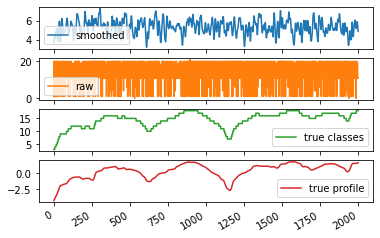

In [25]:
pandas.DataFrame(numpy.vstack([smoothed_predictions[0][100,:],predictions[0][100,:],true[0][100,:],r.train_y_data_smooth[0][100,:]]).transpose(), columns=['smoothed','raw','true classes','true profile']).plot(subplots=True)


Plots the best and worst profile predictions (measured by pearson correlations)

In [26]:
model.plot_profile_predictions(smoothed_predictions, r.train_y_data_smooth,  out_dir=test_plot_dir, what='training')

If you 're interested in the metrics and loss vs training epochs, you can look at the training history plots: 

In [27]:
model.plot_training_history(out_dir=test_plot_dir)

And finally, to plot predictions of whole chromosome (or all sequences in r.chr_info if chr_name=None) do: 

In [28]:
model.save_chr_predictions(runtime_dataset=r,out_dir=test_plot_dir,chr_name='chr1')

Receptive Field: 2047 
Receptive Field: 2047 


Finally, to do it all in one go as we are doing it in the `train` function: 

In [29]:
model.plot_all_training_history(r,f) # not running it - it's already in your training output file! 

Plotting distribution of class predictions, confusion matrices, and  best/worst predictions profiles...
Plotting the confusion matrix for training set.....
Normalized confusion matrix


/home/cakiroa/projects/ChromWave_python3/chromwave/vis/plot.py:130: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


Plotting the confusion matrix for test set.....
Normalized confusion matrix


/home/cakiroa/projects/ChromWave_python3/chromwave/vis/plot.py:130: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]


Plotting the confusion matrix for validation set.....
Normalized confusion matrix


# Loading and saving ChromWave models

There are different ways of saving and loading ChromWave model. The cleanest and most complete way is to deserialise the whole model. To do that you need the setup json and the keras model: 

In [30]:
model._neural_network.save(os.path.join(test_plot_dir, 'BestWaveNet.h5'))
model.serialize_json(output_filepath=os.path.join(test_plot_dir, 'WaveNet_Setup.json'))

{'input_nodes_number': 2000,
 'n_channels': 4,
 'n_output_features': 1,
 'n_output_bins': [22],
 'max_epochs': 2,
 'minibatch_size': 32,
 'early_stopping_patience_fraction': 3,
 'momentum': 0.9,
 'learning_rate': 0.002,
 'weight_decay': 0.0,
 'nesterov': True,
 'optimizer': 'adam',
 'epsilon': 0.001,
 'dropout': 0.2,
 'res_dropout': 0.1,
 'res_l2': 0.01,
 'final_l2': 0.05,
 'penalise_misclassification': False,
 'penalties': [None],
 'class_weights': [[1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0]],
 'preprocessing_params': [{'times_median_coverage_max': 3,
   'discretize_function': 'float_to_int',
   'assign_non_covered_bases': None,
   'u': 2.5,
   'smooth_signal': True,
   'sigma': 5,
   'truncate': 3,
   'smoothing_function': 'gaussian_filter1d',
   'x_thresh': 0,
   'run_thresh': 50,
   'normalise_read_counts': None}],
 'batch_normalization': True,
 '_pretr

In [31]:
model.deserialize(test_plot_dir)

Receptive Field: 2047 


However, the keras model stored in `model._neural_network` can be saved with `keras` functions as `json` or `h5py` files. Even more bareboned is to store the keras weights. Note however, that only loading as a ChromWave model will provide the model with the right loss function. 

In [32]:
# save the model_neural_network as keras model: 
model.save_model( output_path=test_plot_dir, id="keras_model")

We can just load the model as a keras model but we need to pass the loss and metrcs as custom objects. 

In [33]:
import keras
from chromwave.functions import utils
keras_model = keras.models.load_model(os.path.join(test_plot_dir, "keras_model.h5"),
                                      custom_objects={'w_categorical_crossentropy0': model.loss[0],
                                                      'categorical_mean_squared_error':utils.categorical_mean_squared_error,
                                                      'mean_classification_pearson_correlation': utils.mean_classification_pearson_correlation
})


This is of course a nuisance and unnessesary if we just want to make predictions with the keras model. As a workaround you can save the model json and the weights that can be loaded later into a keras model. Note that if the model is used only for prediction of raw classes, then loading a keras model will suffice, however, to provide the smoothed binding profiles additional smoothing with the function `invert_discretizing` provided in the RuntimeDataset object is necessary. 

In [34]:
# saving json and weights
model_json = model._neural_network.to_json()
with open(os.path.join(test_plot_dir, "keras_model.json"), "w") as json_file:
    json_file.write(model_json)
model.save_weights_to(test_plot_dir, id="keras_model")


In [35]:
json_file = open(os.path.join(test_plot_dir, "keras_model.json"), 'r')
keras_json = json_file.read()
json_file.close()
keras_model = keras.models.model_from_json(keras_json)
keras_model.load_weights(os.path.join(test_plot_dir,'keras_model.weights'))

This is why we always store the json and weights after a training run: 

In [36]:
json_file = open(os.path.join(f.get_output_directory(), "model.json"), 'r')
keras_json = json_file.read()
json_file.close()
keras_model = keras.models.model_from_json(keras_json)
keras_model.load_weights(os.path.join(f.get_output_directory(),'BestWaveNet.weights'))

In [37]:
y_pred = [keras_model.predict(r.train_x_data)] # we are expecting the predictions to be a list of arrays 
predictions = [y.argmax(axis=2) for y in y_pred] # classes
predictions_smooth = model.predict_smooth(r.train_x_data)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5758c99d0>,
      dtype=object)

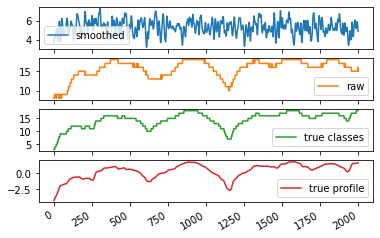

In [38]:
pandas.DataFrame(numpy.vstack([smoothed_predictions[0][100,:],predictions[0][100,:],true[0][100,:],r.train_y_data_smooth[0][100,:]]).transpose(), columns=['smoothed','raw','true classes','true profile']).plot(subplots=True)


# Loading pretrained model weights

Pretrained model weights can be loaded either from saved `keras` models, saved `ChromWave` models or as saved `numpy` array. 

Let's use the pre-trained filters from our keras model that predicts nucleosome binding given a DNA-sequence based on the Chemcial Cleavage data from `Brogaard et al 2012`. 

In [39]:
nuc_model=os.path.join(model_dir,'nucleosomes/brogaard2012_nucModel_6.h5')

Let's pool the pretrained layers and load the convolutional weights of the model trained on the Brogaard data. The ChromWave function `_load_conv_weights` returns the convolutional weights and biases.

In [40]:
model._pool_pretrained_conv=['global']
model._load_conv_weights(nuc_model, 'keras')

/home/cakiroa/software/miniconda3/envs/chromwave/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


[array([[[ 4.66615371e-02,  7.36842975e-02,  1.34514481e-01, ...,
          -5.05942822e-01, -2.25814171e-02, -1.37842238e-01],
         [-4.46681753e-02, -4.10924911e-01, -2.82709658e-01, ...,
           1.52719140e-01, -1.07457452e-02,  1.91821113e-01],
         [-1.79955706e-01,  2.55427230e-02,  8.19325671e-02, ...,
          -3.82968783e-01, -9.05162543e-02,  1.79694816e-02],
         [-4.30578068e-02, -9.05019343e-02, -1.87613800e-01, ...,
           9.37014520e-02, -1.97507674e-03, -3.79237175e-01]],
 
        [[ 7.27666169e-03,  2.05407683e-02,  3.06225084e-02, ...,
          -4.28343087e-01, -2.26044729e-01, -9.87959467e-03],
         [-3.76675725e-01,  1.42846666e-02, -4.22633201e-01, ...,
          -3.71496886e-01,  1.08102202e-01, -1.82060853e-01],
         [-2.67348051e-01,  1.17250606e-01, -9.81899574e-02, ...,
          -3.85653347e-01, -4.18530464e-01, -2.28208438e-01],
         [ 6.67454228e-02, -4.30497378e-01,  1.58322994e-02, ...,
           1.65233165e-01,  7.65468

We can easliy rebuild the model passing the path to the directory of the pretrained model and the type of model, e.g. in this case it's a keras model. The other options are `numpy` if the weights and biases were saved as numpy arrays, or `chromwave` which is a pretrained ChromWave model. We are here only passing one model but you can pass several as a list of directories, and you can also pass keras and chromwave models. 

In [41]:
model =  chromwavenet.ChromWaveNet()
model.build(r, pretrained_models = {'keras': [nuc_model]})

Loading pre-trained model weights 0/1


/home/cakiroa/software/miniconda3/envs/chromwave/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Pooling not specified for pretrained models. Defaulting to global max pooling pretrained models.
Defaulting to training all pretrained layers. These layers will be called conv_i_pretrained.
Receptive Field: 2047 


# Class weights and weighted misclassifications

Because these data are highly imbalanced with the genomic average occurring mostly, we emply weighing of the predictions depending on the frequency of the classes by default. You can see those weights for each output profile using the method `model.class_weights`. To use these classes during training, you need to set the flag `weight_classes` to `True`. 

In [42]:
model.class_weights

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.])]

In [43]:
model.max_epochs =2
start = time.time()
# rebuilding the model before training  - otherwise we would just continue training the previous model
model.train(r,f, rebuild=True, weight_classes=True)
end=time.time()
print('Time: ' + str((end-start)/60.)+' mins')

Receptive Field: 2047 
Train on 6626 samples, validate on 1756 samples
Epoch 1/2
6626/6626 [==============================] - 44s 7ms/step - loss: 69976.5969 - categorical_accuracy: 0.0635 - categorical_mean_squared_error: 39.6058 - mean_classification_pearson_correlation: 0.2877 - val_loss: 58994.7701 - val_categorical_accuracy: 0.1116 - val_categorical_mean_squared_error: 10.2909 - val_mean_classification_pearson_correlation: 0.7420
Epoch 2/2
6626/6626 [==============================] - 35s 5ms/step - loss: 56786.4781 - categorical_accuracy: 0.1396 - categorical_mean_squared_error: 9.2404 - mean_classification_pearson_correlation: 0.6436 - val_loss: 51739.0994 - val_categorical_accuracy: 0.2203 - val_categorical_mean_squared_error: 3.3273 - val_mean_classification_pearson_correlation: 0.8389
Saving model to file ... 
Performance of model on trainings data: 
6626/6626 [==============================] - 9s 1ms/step
[49662.75512909018, 0.20906059443950653, 4.384615421295166, 0.774594187

In addition to the weighing of the predictions depending on the frequency of the classes, you can also weight the predictions so that incorrectly predicted higher classes have a higher influcence on the loss function than misclassification around the genomic mean. You need to pass an array with the desired weights to `model.penalties` and also set the flat `model.penalise_miscalssification` to `True`:

In [44]:
w_array = numpy.ones((r._output_bins[0], r._output_bins[0]))
z = int(numpy.ceil(r._output_bins[0] / 2.))
w_array[:z, -z:] = numpy.logspace(1, 1.2, num=z)
w_array[-z:, :z] = numpy.logspace(1.2, 1, num=z)
model.penalties = [w_array]
model.penalise_misclassification = True

In [45]:
model.keras_verbose = 0# turning off some verbose during training
start = time.time()
# 
model.train(r,f, pretrained_models = {'keras': [nuc_model]},rebuild=True, weight_classes=True)
end=time.time()
print('Time: ' + str((end-start)/60.)+' mins')

Loading pre-trained model weights 0/1


/home/cakiroa/software/miniconda3/envs/chromwave/lib/python3.7/site-packages/keras/engine/saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Receptive Field: 2047 
Saving model to file ... 
Performance of model on trainings data: 
6626/6626 [==============================] - 10s 2ms/step
[95469.23633048314, 0.1916569620370865, 6.605769157409668, 0.764873743057251]
Performance of model on test data: 
1114/1114 [==============================] - 2s 2ms/step
[92292.06559274012, 0.1749551147222519, 6.628571510314941, 0.7729658484458923]
Performance of model on validation data: 
1756/1756 [==============================] - 3s 2ms/step
[88426.92805025626, 0.2010640650987625, 5.363636493682861, 0.8300610780715942]
Plotting training history...
Plotting distribution of class predictions, confusion matrices, and  best/worst predictions profiles...
Plotting the confusion matrix for training set.....
Normalized confusion matrix
Plotting the confusion matrix for test set.....
Normalized confusion matrix
Plotting the confusion matrix for validation set.....
Normalized confusion matrix
Computing motif detectors ...
Computing the PFMs of t

ResourceExhaustedError:  OOM when allocating tensor with shape[6626,256,1,2000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node conv_0_pretrained_1/convolution (defined at /home/cakiroa/software/miniconda3/envs/chromwave/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_303295]

Function call stack:
keras_scratch_graph
